# **Ensembles of Decision Trees**

Ensembles are methods that combine multiple machine learning models to create more powerful models. There are many models in the machine learning literature that belong to this category, but there are **two ensemble models that have proven to be effective** on a wide range of datasets for classification and regression, both of which use decision trees as their building blocks: **random forests and gradient boosted decision trees.**

> **1. Random forests**

As we have observed, **a main drawback of decision trees** is that they tend to overfit the training data. *Random forests are one way to address this problem.*

**A random forest is essentially a collection of decision trees, where each tree is slightly different from the others.** *The idea behind random forests is that each tree might do a relatively good job of predicting, but will likely overfit on part of the data. If we build many trees, all of which work well and overfit in different ways, we can reduce the amount of overfitting by averaging their results.* This reduction in overfitting, while retaining the predictive power of the trees, can be shown using rigorous mathematics.

**To implement this strategy, we need to build many decision trees.** Each tree should do an acceptable job of predicting the target, and should also be different from the other trees. **Random forests get their name from injecting randomness into the tree building to ensure each tree is different.** There are **two ways** in which the trees in a random forest are randomized: by selecting the data points used to build a tree and by selecting the features in each split test. Let’s go into this process in more detail.


> **Building random forests**

To build a random forest model, you need to decide on the number of trees to build (the **n_estimators** parameter of **RandomForestRegressor** or **RandomForestClassifier**). Let’s say we want to build 10 trees. These trees will be built completely independently from each other, and the algorithm will make different random choices for each tree to make sure the trees are distinct.

To build a tree, we first take what is called a **bootstrap sample** of our data. That is, from our **n_samples** data points, we repeatedly draw an example randomly with replacement (meaning the same sample can be picked multiple times), several times.


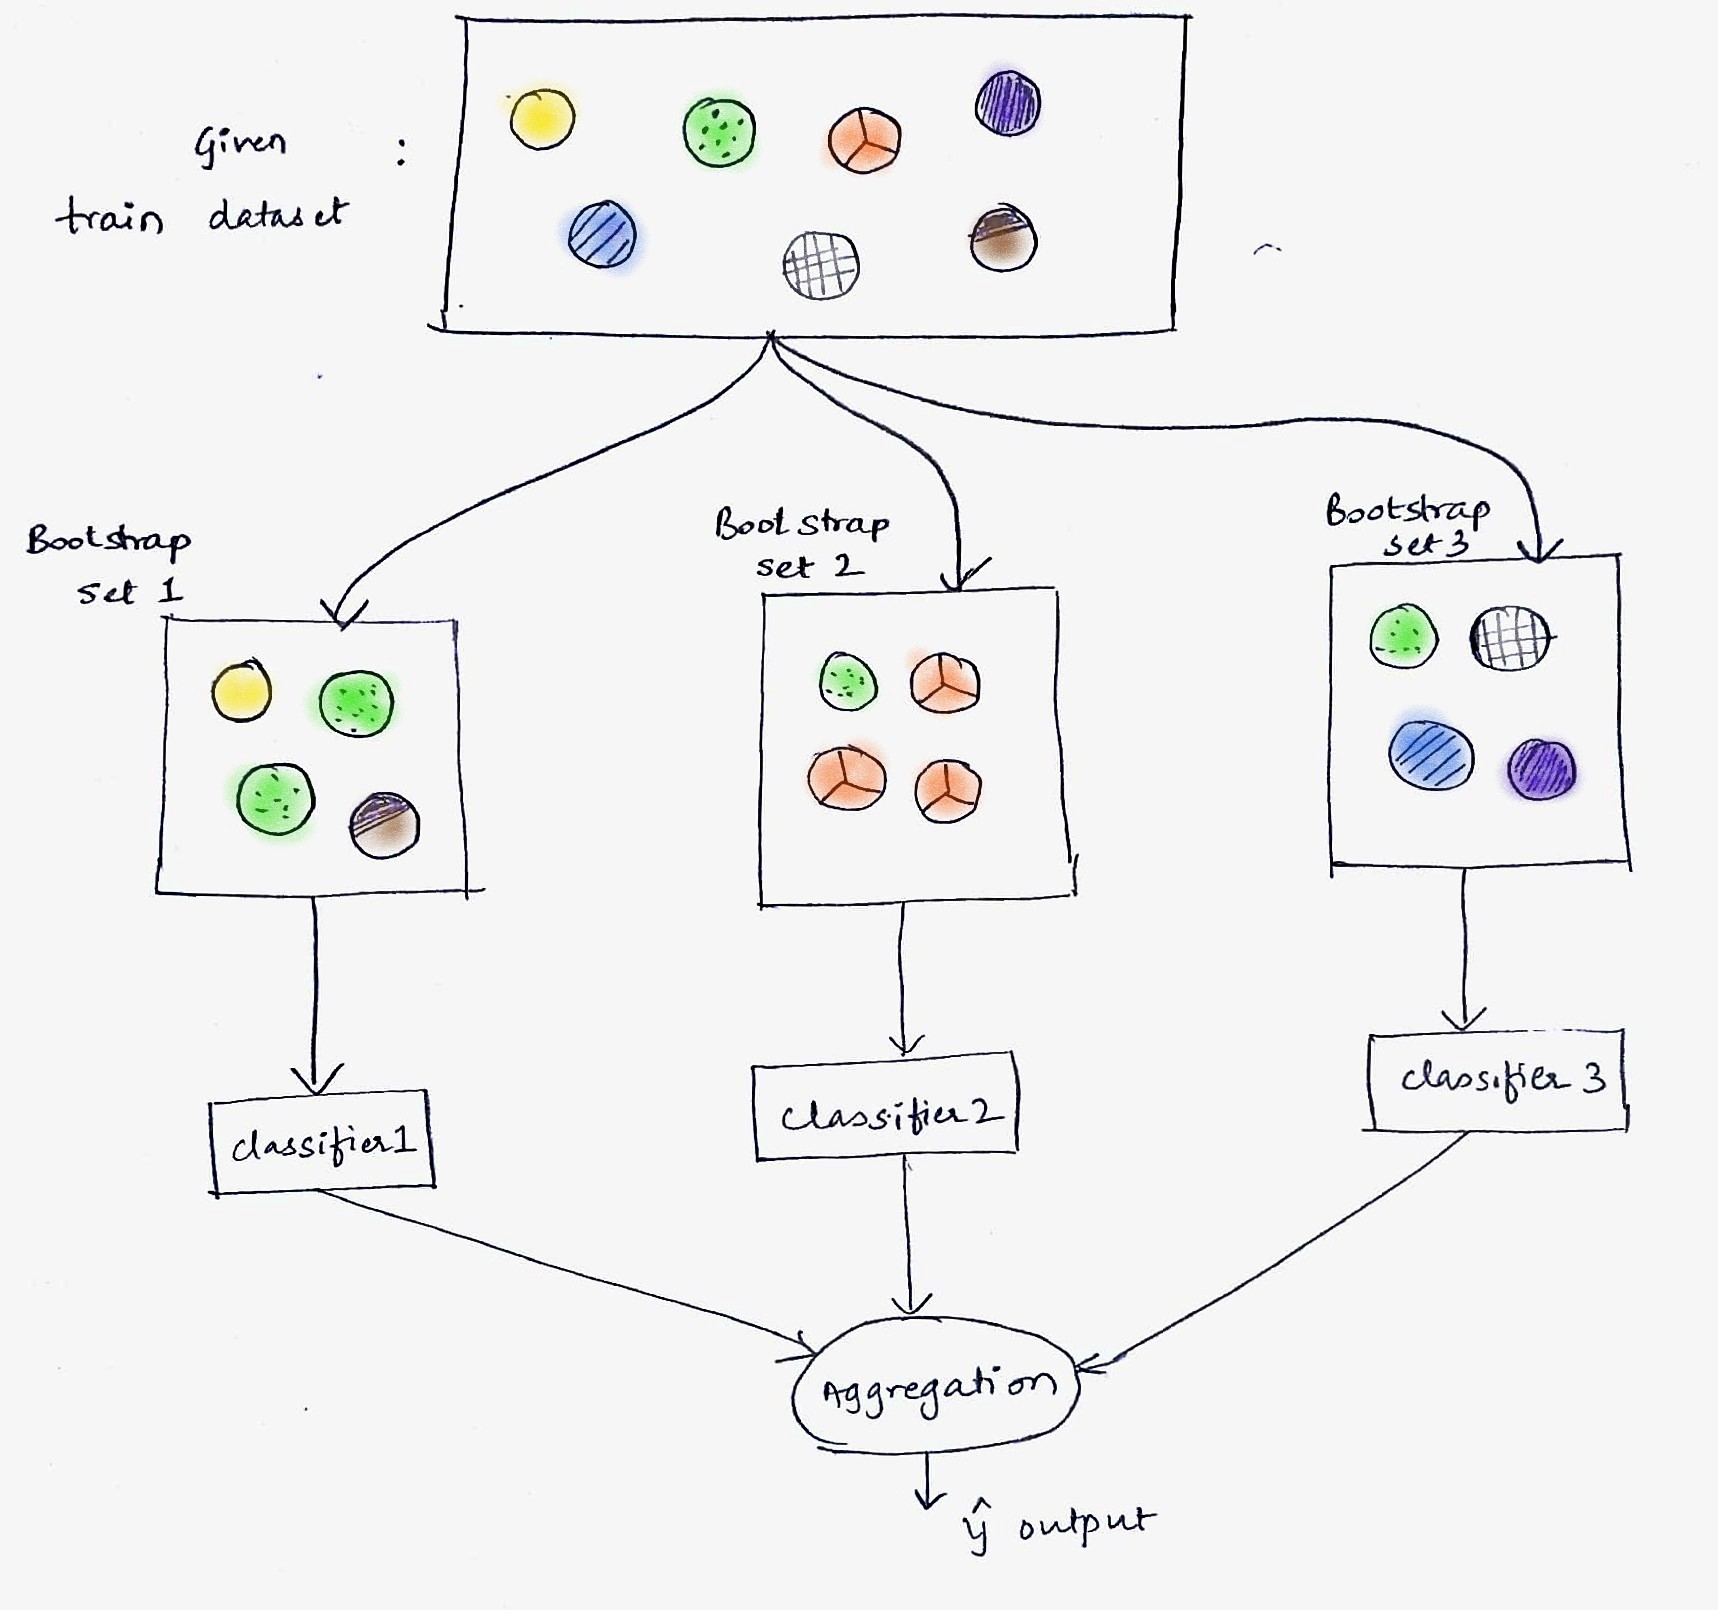

In [1]:
from IPython.core.display import Image, display
display(Image('https://i.ibb.co/HxtHMf9/10.jpg', width=500, unconfined=True))

This will create a dataset where some data points will be missing from the original dataset, and some will be repeated.

To give you one more example, let’s say we want to create a bootstrap sample of the list ['a', 'b', 'c', 'd']. A possible bootstrap sample would be ['b', 'd', 'd', 'c']. Another possible sample would be ['d', 'a', 'd', 'a'].

Next, a decision tree is built based on this newly created dataset. However, the algorithm we described for the decision tree is slightly modified. Instead of looking for the best test for each node, in each node the algorithm randomly selects a subset of the features, and it looks for the best possible test involving one of these features. The number of features that are selected is controlled by the **max_features parameter**. This selection of a subset of features is repeated separately in each node, so that each node in a tree can make a decision using a different subset of the features.

The bootstrap sampling leads to each decision tree in the random forest being built on a slightly different dataset. Because of the selection of features in each node, each split in each tree operates on a different subset of features. Together, these two mechanisms ensure that all the trees in the random forest are different.

A critical parameter in this process is **max_features**. If we set **max_features** to **n_features**, that means that each split can look at all features in the dataset, and no randomness will be injected in the feature selection (the randomness due to the bootstrapping remains, though). If we set **max_features** to 1, that means that the splits have no choice at all on which feature to test, and can only search over different thresholds for the feature that was selected randomly. Therefore, a high **max_features** means that the trees in the random forest will be quite similar, and they will be able to fit the data easily, using the most distinctive features. A low **max_features** means that the trees in the random forest will be quite different, and that each tree might need to be very deep in order to fit the data well.

To make a prediction using the random forest, the algorithm first makes a prediction for every tree in the forest. For regression, we can average these results to get our final prediction. For classification, a “soft voting” strategy is used. This means each algorithm makes a “soft” prediction, providing a probability for each possible output label. The probabilities predicted by all the trees are averaged, and the class with the highest probability is predicted.

**Analyzing random forests**

Let’s apply a random forest consisting of five trees to the *two_moons dataset* we studied earlier:


In [2]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=5,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

The trees that are built as part of the random forest are stored in the **estimator_** attribute. Let’s visualize the decision boundaries learned by each tree, together with their aggregate prediction as made by the forest. Below we can see decision boundaries found by five randomized decision trees and the decision boundary obtained by averaging their predicted probabilities:

In [4]:
!pip3 install mglearn

     |████████████████████████████████| 540 kB 8.0 MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582637 sha256=10c22c1c41a738a135b5becd3f6ba5df3c28073ca37629987639f02cf9d0b1ec
  Stored in directory: /root/.cache/pip/wheels/f1/17/e1/1720d6dcd70187b6b6c3750cb3508798f2b1d57c9d3214b08b
Successfully built mglearn


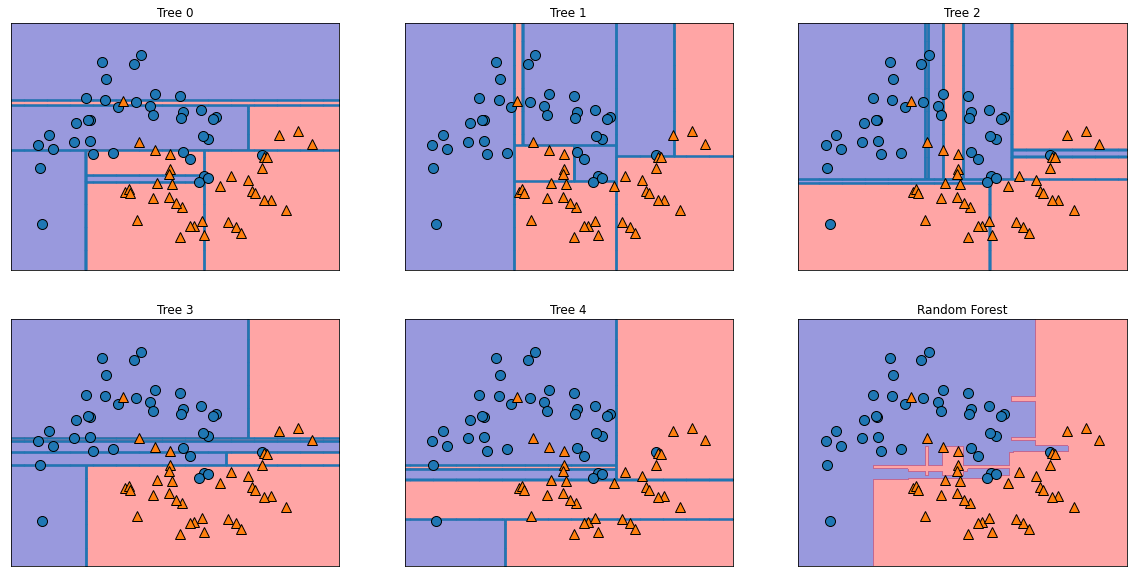

In [5]:
import mglearn
from matplotlib import pyplot as plt

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X_train, y_train, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(forest, X_train, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forest")
mglearn.discrete_scatter(X_train[:, 0], X_train[:, 1], y_train)

You can clearly see that the decision boundaries learned by the five trees are quite different. Each of them makes some mistakes, as some of the training points that are plotted here were not actually included in the training sets of the trees, due to the bootstrap sampling.

The random forest overfits less than any of the trees individually, and provides a much more intuitive decision boundary. In any real application, we would use many more trees (often hundreds or thousands), leading to even smoother boundaries.

As another example, let’s apply a random forest consisting of 100 trees on the Breast Cancer dataset:

In [6]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(forest.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(forest.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.972


The random forest gives us an accuracy of 97%, better than the linear models or a single decision tree, without tuning any parameters. We could adjust the **max_features** setting, or apply pre-pruning as we did for the single decision tree. However, often the default parameters of the random forest already work quite well.

Similarly to the decision tree, the random forest provides feature importances, which are computed by aggregating the feature importances over the trees in the forest. Typically, the feature importances provided by the random forest are more reliable than the ones provided by a single tree. Take a look at figure with feature importances computed from a random forest that was fit to the Breast Cancer dataset:

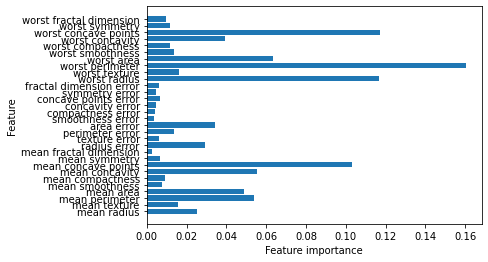

In [7]:
import numpy as np
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    
plot_feature_importances_cancer(forest)

As you can see, the random forest gives non-zero importance to many more features than the single tree. Similarly to the single decision tree, the random forest also gives a lot of importance to the “worst radius” feature, but it actually chooses “worst perimeter” to be the most informative feature overall. The randomness in building the random forest forces the algorithm to consider many possible explanations, the result being that the random forest captures a much broader picture of the data than a single tree.

> **Strengths, weaknesses, and parameters**

Random forests for regression and classification are currently among the **most widely used machine learning methods**. They are very powerful, often work well **without heavy tuning of the parameters, and don’t require scaling of the data.**

Essentially, random forests share all of the benefits of decision trees, while making up for some of their deficiencies. One reason to still use decision trees is if you need a compact representation of the decision-making process. It is basically impossible to interpret tens or hundreds of trees in detail, and **trees in random forests tend to be deeper than decision trees (because of the use of feature subsets)**. Therefore, if you need to summarize the prediction making in a visual way to non-experts, a single decision tree might be a better choice.

While building random forests on large datasets might be **somewhat time consuming**, it can be parallelized across multiple CPU cores within a computer easily. If you are using a multi-core processor (as nearly all modern computers do), you can use the **n_jobs** parameter to adjust the number of cores to use. Using more CPU cores will result in linear speed-ups (using two cores, the training of the random forest will be twice as fast), but specifying **n_jobs** larger than the number of cores will not help. You can set **n_jobs=-1** to use all the cores in your computer.

You should keep in mind that random forests, by their nature, are random, and setting different random states (or not setting the random_state at all) can drastically change the model that is built. *The more trees there are in the forest, the more robust it will be against the choice of random state.* If you want to have reproducible results, it is important to fix the random_state.

**Random forests don’t tend to perform well on very high dimensional, sparse data, such as text data.** For this kind of data, linear models might be more appropriate. *Random forests usually work well even on very large datasets, and training can easily be parallelized over many CPU cores within a powerful computer.* **However, random forests require more memory and are slower to train and to predict than linear models.** If time and memory are important in an application, it might make sense to use a linear model instead.

The important parameters to adjust are **n_estimators**, **max_features**, and possibly pre-pruning options like **max_depth**. For n_estimators, larger is always better. Averaging more trees will yield a more robust ensemble by reducing overfitting. However, there are diminishing returns, and more trees need more memory and more time to train. **A common rule of thumb** is to build “as many as you have time/memory for.”

As described earlier, **max_features** determines how random each tree is, and a smaller max_features reduces overfitting. In general, it’s a **good rule of thumb** to use the default values: max_features=sqrt(n_features) for classification and max_features=log2(n_features) for regression. Adding max_features or max_leaf_nodes might sometimes improve performance. It can also drastically reduce space and time requirements for training and prediction.

> **2. Gradient boosted regression trees (gradient boosting machines)**

The **gradient boosted regression tree** is another ensemble method that combines multiple decision trees to create a more powerful model. *Despite the “regression” in the name, these models can be used for regression and classification.*

In contrast to the random forest approach, gradient boosting works by building trees in a serial manner, where each tree tries to correct the mistakes of the previous one. By default, there is no randomization in gradient boosted regression trees; instead, strong pre-pruning is used. **Gradient boosted trees often use very shallow trees**, of depth one to five, which makes the model smaller in terms of memory and makes predictions faster.

The **main idea behind gradient boosting** is to combine many simple models (in this context known as weak learners), like shallow trees. Each tree can only provide good predictions on part of the data, and so more and more trees are added to iteratively improve performance.

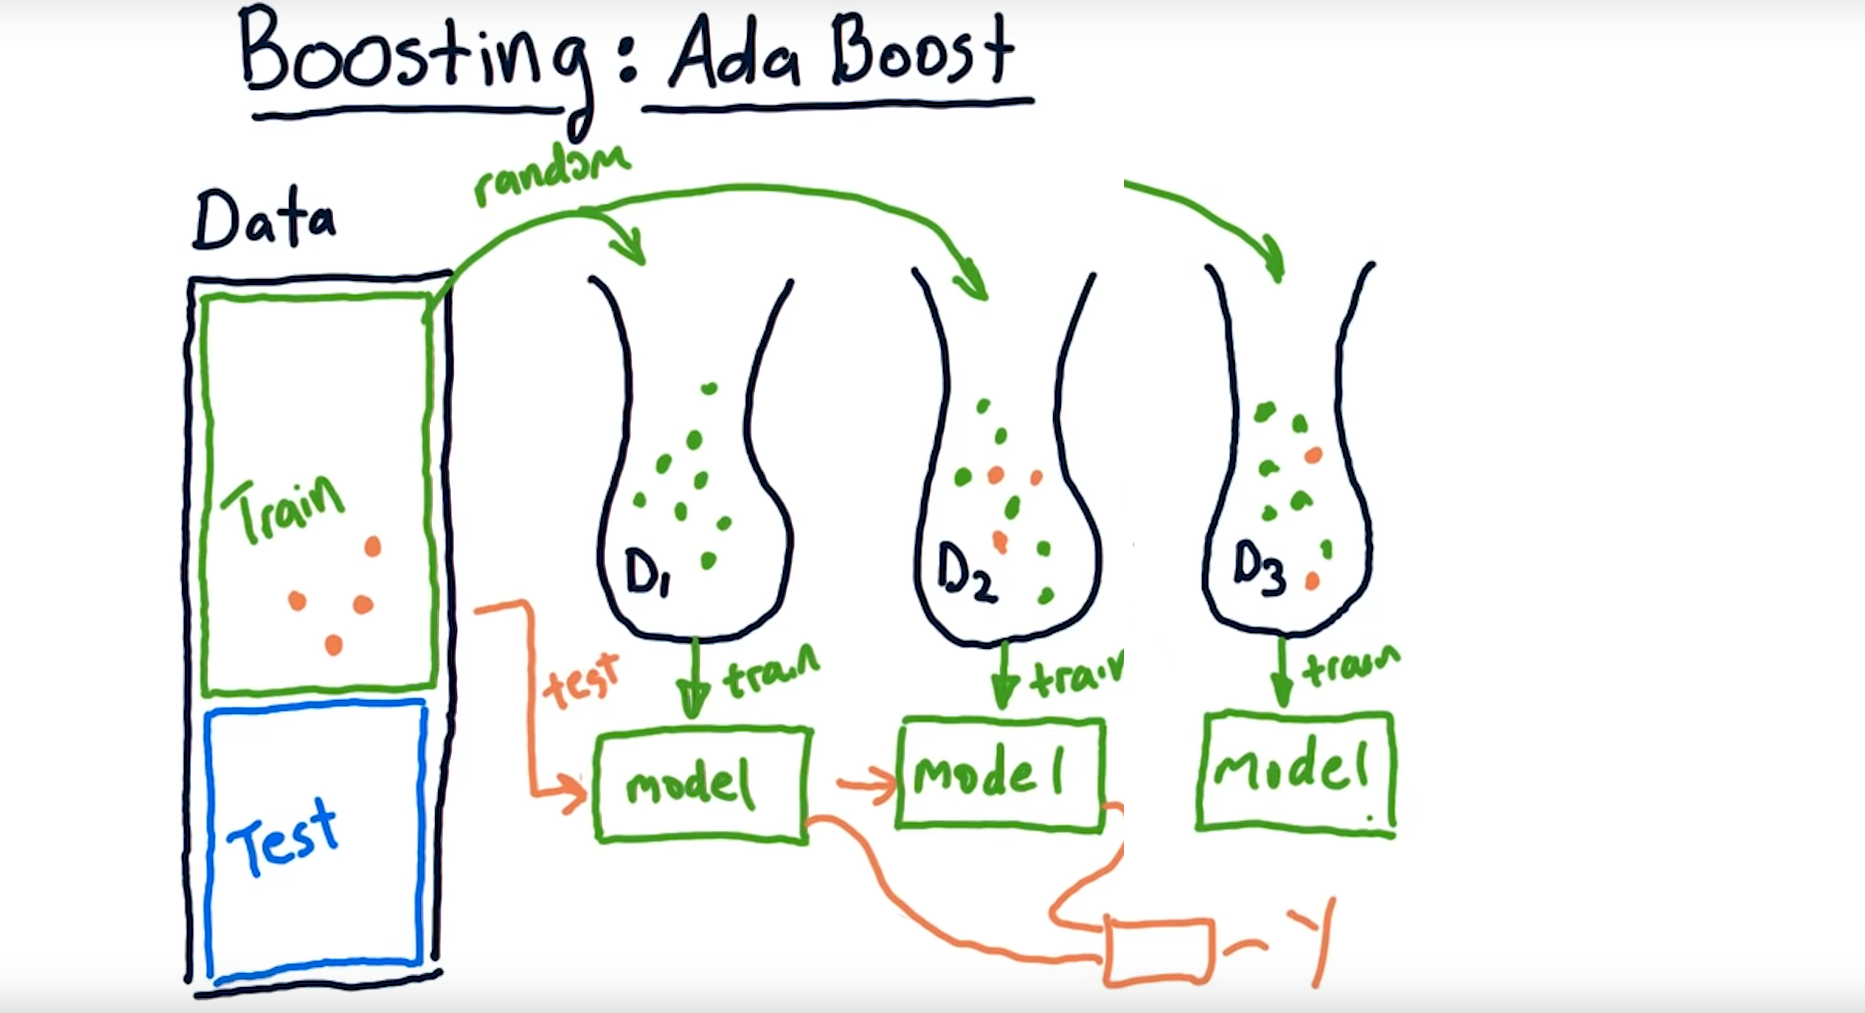

In [8]:
from IPython.core.display import Image, display
display(Image('https://i.ibb.co/NmnkkbB/11.png', width=800, unconfined=True))

We build the first bag of data from a random sample from the training dataset and train the model on this data. Next, we test the trained model on all data in the training set and note which objects our model makes the most mistakes.

Next, we build a new dataset again by randomly selecting samples from the training sample, but this time each of them has a certain weight depending on the error of the first trained model on it. Samples that deliver the largest model error are more likely to get into the new dataset. With this data, we train the second model. We now test our mini-ensemble of the two currently available models on the entire training set and re-memorize the "difficult" samples on which they are most mistaken. Further, in the same way, we build new datasets and new models that correct the errors of the existing ensemble. "Difficult" patterns can, of course, change as our system grows.

In **bagging**, we built several datasets by randomly selecting them from the training set. The idea of **boosting** is very similar, only the data is chosen more "smartly" - those on which the existing models (weak learners) are wrong and which still need to be "learned" better.

Gradient boosted trees are frequently the winning entries in machine learning competitions, and are widely used in industry. They are generally a bit more sensitive to parameter settings than random forests, but can provide better accuracy if the parameters are set correctly.

Apart from the pre-pruning and the number of trees in the ensemble, another important parameter of gradient boosting is the **learning_rate**, which controls how strongly each tree tries to correct the mistakes of the previous trees. A higher learning rate means each tree can make stronger corrections, allowing for more complex models. Adding more trees to the ensemble, which can be accomplished by increasing n_estimators, also increases the model complexity, as the model has more chances to correct mistakes on the training set.

Here is an example of using GradientBoostingClassifier on the Breast Cancer dataset. By default, 100 trees of maximum depth 3 and a learning rate of 0.1 are used:

In [9]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.965


As the training set accuracy is 100%, we are likely to be overfitting. To reduce overfitting, we could, for example, apply stronger pre-pruning by limiting the maximum depth:

In [10]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("Accuracy on training set: {:.3f}".format(gbrt.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(gbrt.score(X_test, y_test)))

Accuracy on training set: 0.991
Accuracy on test set: 0.972


This method of decreasing the model complexity reduced the training set accuracy, as expected. In this case, lowering the maximum depth of the trees provided a significant improvement of the model.

As for the other decision tree–based models, we can again visualize the feature importances to get more insight into our model. As we used 100 trees, it is impractical to inspect them all, even if they are all of depth 1:

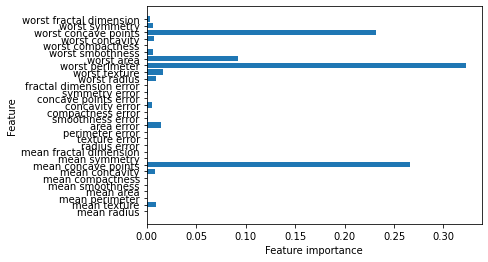

In [11]:
gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

plot_feature_importances_cancer(gbrt)

We can see that the feature importances of the gradient boosted trees are somewhat similar to the feature importances of the random forests, though the gradient boosting completely ignored some of the features.

As both gradient boosting and random forests perform well on similar kinds of data, a common approach is to first try random forests, which work quite robustly. If random forests work well but prediction time is at a premium, or it is important to squeeze out the last percentage of accuracy from the machine learning model, moving to gradient boosting often helps.

If you want to apply gradient boosting to a large-scale problem, it might be worth looking into the **xgboost** package and its Python interface, which at the time of writing is faster (and sometimes easier to tune) than the scikit-learn implementation of gradient boosting on many datasets.

> **Strengths, weaknesses, and parameters**

Gradient boosted decision trees are among the most powerful and widely used models for supervised learning. Their main drawback is that they require careful tuning of the parameters and may take a long time to train. Similarly to other tree-based models, the algorithm works well without scaling and on a mixture of binary and continuous features. As with other tree-based models, it also often does not work well on high-dimensional sparse data.

The main parameters of gradient boosted tree models are the **number of trees**, **n_estimators**, and the **learning_rate**, which controls the degree to which each tree is allowed to correct the mistakes of the previous trees. These two parameters are highly interconnected, as a **lower learning_rate means** that more trees are needed to build a model of similar complexity.

In contrast to random forests, where a higher n_estimators value is always better, increasing n_estimators in gradient boosting leads to a more complex model, which may lead to overfitting. **A common practice** is to fit n_estimators depending on the time and memory budget, and then search over different learning_rates.

Another important parameter is **max_depth** (or alternatively **max_leaf_nodes**), to reduce the complexity of each tree. Usually max_depth is set very low for gradient boosted models, often not deeper than five splits.
